In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

/bin/bash: line 1: nvidia-smi: command not found


# 导入数据

In [ ]:
!pip install ffmpeg"
!pip install geopandas

/bin/bash: -c: line 1: unexpected EOF while looking for matching `"'
/bin/bash: -c: line 2: syntax error: unexpected end of file


In [ ]:
import pandas as pd
import geopandas as gpd
import folium
from shapely import wkt
import os
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import variation
import numpy as np


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
data_path=('/content/drive/MyDrive/CDS 529 Method/')

records_df =pd.read_csv(data_path+'Dataset/records.csv')
records_df


Mounted at /content/drive/


<ipython-input-7-cc58f98b93bd>:5: DtypeWarning: Columns (5,6,7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  records_df =pd.read_csv(data_path+'Dataset/records.csv')


,Unnamed: 0,device_id,latitude,longitude,timestamp,device_home_latitude,device_home_longitude,device_work_latitude,device_work_longitude,location_type,price_sqft_home,price_sqft_location,class,cluster
0,0,f6a013e3-3b28-6d4d-bf34-ab0f00d3493a,22.317195,114.164492,1693968605,22.324516747368424,114.16060220789477,22.324328279999996,114.16006437000001,\N,17674.866666666665,\N,Middle Class,0
1,1,f6a013e3-3b28-6d4d-bf34-ab0f00d3493a,22.321797,114.163416,1694598056,22.324516747368424,114.16060220789477,22.324328279999996,114.16006437000001,\N,17674.866666666665,\N,Middle Class,0
2,2,f6a013e3-3b28-6d4d-bf34-ab0f00d3493a,22.324722,114.160567,1693585894,22.324516747368424,114.16060220789477,22.324328279999996,114.16006437000001,building-apartments,17674.866666666665,17674.866666666665,Middle Class,0
3,3,f6a013e3-3b28-6d4d-bf34-ab0f00d3493a,22.324579,114.160617,1693594236,22.324516747368424,114.16060220789477,22.324328279999996,114.16006437000001,building-apartments,17674.866666666665,17674.866666666665,Middle Class,0
4,4,f6a013e3-3b28-6d4d-bf34-ab0f00d3493a,22.324567,114.160615,1693595736,22.324516747368424,114.16060220789477,22.324328279999996,114.16006437000001,building-apartments,17674.866666666665,17674.866666666665,Middle Class,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17763199,17763199,a074a0bf-18bb-6140-2296-104ebfefeadd,22.288274,114.140126,1693689863,\N,\N,\N,\N,building-apartments,\N,21346.583333333332,High-Middle Class,1
17763200,17763200,a074a0bf-18bb-6140-2296-104ebfefeadd,22.288203,114.140126,1693691068,\N,\N,\N,\N,building-apartments,\N,21346.583333333332,High-Middle Class,1
17763201,17763201,a074a0bf-18bb-6140-2296-104ebfefeadd,22.288193,114.140112,1693691685,\N,\N,\N,\N,building-apartments,\N,21346.583333333332,High-Middle Class,1
17763202,17763202,a074a0bf-18bb-6140-2296-104ebfefeadd,22.288289,114.140144,1693692331,\N,\N,\N,\N,building-apartments,\N,21346.583333333332,High-Middle Class,1


In [ ]:
class_counts =records_df['class'].value_counts()
class_counts

class
Low Class            7593162
Middle Class         7219236
High-Middle Class    2539052
High Class            411754
Name: count, dtype: int64

<ipython-input-9-7fcf4d08ad03>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=records_df, x='class', order=class_labels, palette='viridis')


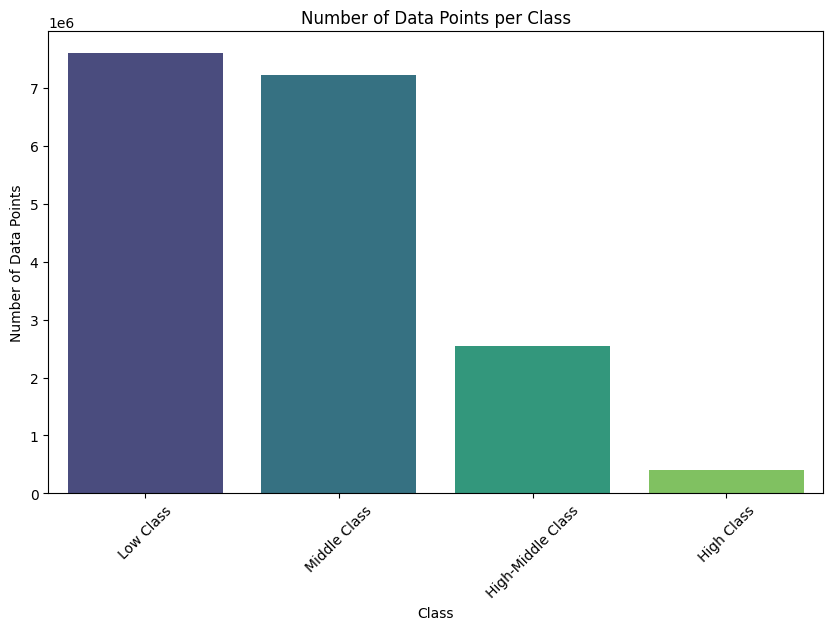

In [ ]:
# Plot the count of each class using Seaborn
class_labels = ['Low Class', 'Middle Class', 'High-Middle Class', 'High Class']
plt.figure(figsize=(10, 6))
sns.countplot(data=records_df, x='class', order=class_labels, palette='viridis')
plt.xlabel('Class')
plt.ylabel('Number of Data Points')
plt.title('Number of Data Points per Class')
plt.xticks(rotation=45)

plt.show()

# 加入Geometry 与 TPU表 关联

In [ ]:
# TPU 读取
gfs = []
for f in os.listdir(data_path+ '/tpu_data_geo/'):
    if 'shp' not in f:
        continue
    if '._' in f:
        continue
    ## GBK for encode Chinese
    shapefile = gpd.read_file( data_path + '/tpu_data_geo/%s' % f, encoding="GBK")
    tupid = f.split('_')[1].split('.')[0]
    shapefile['tpuid'] = tupid
    ## set crs
    shapefile.crs = 'EPSG:4326'
    gfs.append(shapefile)
gfs = gpd.GeoDataFrame(pd.concat(gfs))

## select two columns only
sel_cols = ['tpuid', 'geometry']
gfs_sel = gfs[sel_cols]

In [ ]:
geometry = gpd.points_from_xy(records_df['longitude'], records_df['latitude'])
merged_gdf = gpd.GeoDataFrame(records_df, geometry=geometry)
merged_gdf.crs = "EPSG:4326"


In [ ]:
merged = gpd.sjoin(gfs_sel, merged_gdf, how='left', op='intersects')
merged['date'] = pd.to_datetime(merged["timestamp"], unit='s') + pd.Timedelta(days=8/24)

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3473: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


In [ ]:
df_new = merged[['tpuid', 'geometry', 'device_id','date', 'class', 'cluster','latitude','longitude']]
df_new.crs = "EPSG:4326"
df_new

,tpuid,geometry,device_id,date,class,cluster,latitude,longitude
0,976,"MULTIPOLYGON (((114.04660 22.28246, 114.04659 ...",8cf85ef1-39e4-416d-b520-02d6288e01c5,2023-09-14 13:07:15,Middle Class,0,22.280340,114.040560
0,976,"MULTIPOLYGON (((114.04660 22.28246, 114.04659 ...",04f1d360-67e3-4e13-83ea-87330519b703,2023-09-08 09:18:31,Middle Class,0,22.280617,114.039917
0,976,"MULTIPOLYGON (((114.04660 22.28246, 114.04659 ...",04f1d360-67e3-4e13-83ea-87330519b703,2023-09-12 15:40:46,Middle Class,0,22.280618,114.039964
0,976,"MULTIPOLYGON (((114.04660 22.28246, 114.04659 ...",04f1d360-67e3-4e13-83ea-87330519b703,2023-09-12 15:25:44,Middle Class,0,22.280618,114.039964
0,976,"MULTIPOLYGON (((114.04660 22.28246, 114.04659 ...",c2db6302-1cc6-4866-94ed-a00c3010224d,2023-09-09 15:46:15,High-Middle Class,1,22.281822,114.040727
...,...,...,...,...,...,...,...,...
0,971S,"MULTIPOLYGON (((114.07899 22.28688, 114.07901 ...",1d25e7b3-41a9-42b2-9760-31a50f41b070,2023-09-10 15:28:21,Middle Class,0,22.319072,113.999676
0,971S,"MULTIPOLYGON (((114.07899 22.28688, 114.07901 ...",aa627d9c-420c-6280-1fea-d086cbd7cec9,2023-09-08 09:45:29,Middle Class,0,22.319073,113.999676
0,971S,"MULTIPOLYGON (((114.07899 22.28688, 114.07901 ...",1d25e7b3-41a9-42b2-9760-31a50f41b070,2023-09-10 15:28:59,Middle Class,0,22.319080,113.999676
0,971S,"MULTIPOLYGON (((114.07899 22.28688, 114.07901 ...",27a93a8b-7b64-4f4a-a6ca-d6a75ead3dba,2023-09-04 18:56:02,Low Class,3,22.319081,113.999564


# 封装计算函数（辛普森，Evenness，信息熵）

In [ ]:
import pandas as pd

def calculate_simpson_index(df, class_col, tpu_col, time_col, device_col):
    """
    Calculate Simpson's Diversity Index for each TPU at each hour point, counting each device only once per hour.
    :param df: Pandas DataFrame with the data.
    :param class_col: Column name for the class/category.
    :param tpu_col: Column name for the TPU identifier.
    :param time_col: Column name for the time.
    :param device_col: Column name for the device identifier.
    :return: DataFrame with TPU ID, timestamp, and corresponding Simpson Index.
    """
    # Create an empty DataFrame to store Simpson Index for each TPU and time point
    simpson_df = pd.DataFrame()

    # Convert time_col to datetime and round to the nearest hour for proper grouping
    df[time_col] = pd.to_datetime(df[time_col]).dt.floor('H')

    # Removing duplicates based on device_id per TPU and per hour
    df_unique = df.drop_duplicates(subset=[tpu_col, time_col, device_col])

    # Group the data by TPU and time
    grouped = df_unique.groupby([tpu_col, time_col])

    # List to hold DataFrame fragments
    results = []

    # Iterate over each group
    for name, group in grouped:
        tpu_id, time_hour = name
        # Count the frequency of each class in the current group
        class_counts = group[class_col].value_counts()
        total = class_counts.sum()
        # Calculate the Simpson Index for the group
        simpson_index = 1 - sum((n / total) ** 2 for n in class_counts)
        # Create a DataFrame for this result
        result_df = pd.DataFrame({
            tpu_col: [tpu_id],
            time_col: [time_hour],
            'Simpson_Index': [simpson_index],
            'Simpson_Total':[total]
        })
        # Append the result DataFrame to the results list
        results.append(result_df)

    # Concatenate all results into the final DataFrame
    simpson_df = pd.concat(results, ignore_index=True)

    # Sorting by TPU and time for readability
    simpson_df.sort_values(by=[tpu_col, time_col], inplace=True)

    return simpson_df
    return total

def calculate_Evenness_Index(df, class_col, tpu_col, time_col, device_col):
    df[time_col] = pd.to_datetime(df[time_col]).dt.floor('H')
    df_unique = df.drop_duplicates(subset=[tpu_col, time_col, device_col])
    grouped = df_unique.groupby([tpu_col, time_col])

    results = []

    for name, group in grouped:
        tpu_id, time_hour = name
        class_counts = group[class_col].value_counts()
        total = class_counts.sum()
        proportions = class_counts / total
        shannon_index = -np.sum(proportions * np.log(proportions))
        max_shannon = np.log(len(class_counts)) if len(class_counts) > 0 else 0
        evenness_index = shannon_index / max_shannon if max_shannon > 0 else 0

        result_df = pd.DataFrame({
            tpu_col: [tpu_id],
            time_col: [time_hour],
            'Evenness_Index': [evenness_index]
        })
        results.append(result_df)

    gini_df = pd.concat(results, ignore_index=True)
    gini_df.sort_values(by=[tpu_col, time_col], inplace=True)

    return gini_df


def calculate_entropy(df, class_col, tpu_col, time_col, device_col):
    df[time_col] = pd.to_datetime(df[time_col]).dt.floor('H')
    df_unique = df.drop_duplicates(subset=[tpu_col, time_col, device_col])
    grouped = df_unique.groupby([tpu_col, time_col])

    results = []

    for name, group in grouped:
        tpu_id, time_hour = name
        class_counts = group[class_col].value_counts()
        probabilities = class_counts / class_counts.sum()
        entropy = -np.sum(probabilities * np.log2(probabilities + (probabilities == 0)))

        result_df = pd.DataFrame({
            tpu_col: [tpu_id],
            time_col: [time_hour],
            'Entropy': [entropy]
        })
        results.append(result_df)

    entropy_df = pd.concat(results, ignore_index=True)
    entropy_df.sort_values(by=[tpu_col, time_col], inplace=True)

    return entropy_df

In [ ]:
# 计算辛普森指数
simpson_df = calculate_simpson_index(df_new, 'class', 'tpuid', 'date' ,'device_id')
simpson_df

/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,tpuid,date,Simpson_Index,Simpson_Total
0,111,2023-09-01 08:00:00,0.559118,165
1,111,2023-09-01 09:00:00,0.617646,195
2,111,2023-09-01 10:00:00,0.629341,201
3,111,2023-09-01 11:00:00,0.604155,190
4,111,2023-09-01 12:00:00,0.607813,227
...,...,...,...,...
68260,976,2023-09-14 17:00:00,0.500000,2
68261,976,2023-09-14 18:00:00,0.500000,2
68262,976,2023-09-14 19:00:00,0.000000,1
68263,976,2023-09-14 20:00:00,0.000000,1


from matplotlib import pyplot as plt
simpson_df['Simpson_Index'].plot(kind='hist', bins=20, title='Simpson_Index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
simpson_df['Simpson_Total'].plot(kind='hist', bins=20, title='Simpson_Total')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
simpson_df.plot(kind='scatter', x='Simpson_Index', y='Simpson_Total', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['date']
  ys = series['Simpson_Index']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = simpson_df.sort_values('date', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('date')
_ = plt.ylabel('Simpson_Index')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['date']
  ys = series['Simpson_Total']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = simpson_df.sort_values('date', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('date')
_ = plt.ylabel('Simpson_Total')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['date']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'date'}, axis=1)
              .sort_values('date', ascending=True))
  xs = counted['date']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = simpson_df.sort_values('date', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('date')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['date']
  ys = series['Simpson_Index']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = simpson_df.sort_values('date', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('date')
_ = plt.ylabel('Simpson_Index')

from matplotlib import pyplot as plt
simpson_df['Simpson_Index'].plot(kind='line', figsize=(8, 4), title='Simpson_Index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
simpson_df['Simpson_Total'].plot(kind='line', figsize=(8, 4), title='Simpson_Total')
plt.gca().spines[['top', 'right']].set_visible(False)

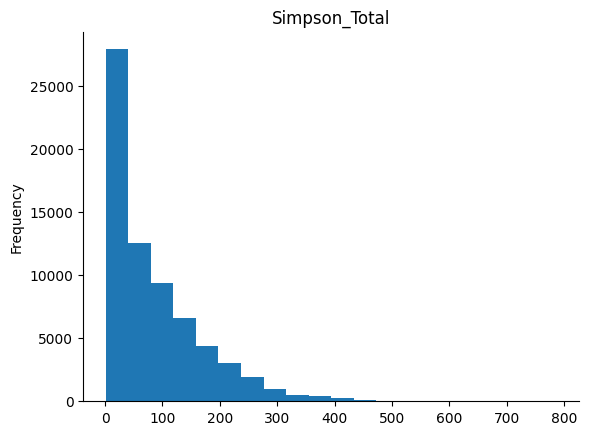

In [ ]:
from matplotlib import pyplot as plt
simpson_df['Simpson_Total'].plot(kind='hist', bins=20, title='Simpson_Total')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
Evenness_df = calculate_Evenness_Index(df_new, 'class', 'tpuid', 'date', 'device_id')

/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [ ]:
Evenness_df

,tpuid,date,Evenness_Index
0,111,2023-09-01 08:00:00,0.669479
1,111,2023-09-01 09:00:00,0.787274
2,111,2023-09-01 10:00:00,0.808032
3,111,2023-09-01 11:00:00,0.758401
4,111,2023-09-01 12:00:00,0.770307
...,...,...,...
68260,976,2023-09-14 17:00:00,1.000000
68261,976,2023-09-14 18:00:00,1.000000
68262,976,2023-09-14 19:00:00,0.000000
68263,976,2023-09-14 20:00:00,0.000000


In [ ]:
entropy_df = calculate_entropy(df_new, 'class', 'tpuid', 'date', 'device_id')
entropy_df

/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,tpuid,date,Entropy
0,111,2023-09-01 08:00:00,1.338957
1,111,2023-09-01 09:00:00,1.574547
2,111,2023-09-01 10:00:00,1.616064
3,111,2023-09-01 11:00:00,1.516802
4,111,2023-09-01 12:00:00,1.540614
...,...,...,...
68260,976,2023-09-14 17:00:00,1.000000
68261,976,2023-09-14 18:00:00,1.000000
68262,976,2023-09-14 19:00:00,-0.000000
68263,976,2023-09-14 20:00:00,-0.000000


In [ ]:
combined_df = pd.merge(simpson_df, Evenness_df, how='inner', on=['tpuid', 'date'])
dis_df = pd.merge(combined_df, entropy_df, how='inner', on=['tpuid', 'date'])
dis_df

,tpuid,date,Simpson_Index,Simpson_Total,Evenness_Index,Entropy
0,111,2023-09-01 08:00:00,0.559118,165,0.669479,1.338957
1,111,2023-09-01 09:00:00,0.617646,195,0.787274,1.574547
2,111,2023-09-01 10:00:00,0.629341,201,0.808032,1.616064
3,111,2023-09-01 11:00:00,0.604155,190,0.758401,1.516802
4,111,2023-09-01 12:00:00,0.607813,227,0.770307,1.540614
...,...,...,...,...,...,...
68260,976,2023-09-14 17:00:00,0.500000,2,1.000000,1.000000
68261,976,2023-09-14 18:00:00,0.500000,2,1.000000,1.000000
68262,976,2023-09-14 19:00:00,0.000000,1,0.000000,-0.000000
68263,976,2023-09-14 20:00:00,0.000000,1,0.000000,-0.000000


In [ ]:
dis_df.to_csv(data_path + 'Calculate_TPU_index.csv', index=False)